# Problem Statement

Yulu is India’s leading micro-mobility service provider, which offers unique vehicles for the daily commute. Starting off as a mission to eliminate traffic congestion in India, Yulu provides the safest commute solution through a user-friendly mobile app to enable shared, solo and sustainable commuting.
Yulu zones are located at all the appropriate locations (including metro stations, bus stands, office spaces, residential areas, corporate offices, etc) to make those first and last miles smooth, affordable, and convenient!
Yulu has recently suffered considerable dips in its revenues. They want to know-
- Which variables are significant in predicting the demand for shared electric cycles in the Indian market?
- How well those variables describe the electric cycle demands?

Getting started -

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from scipy.stats import norm, t, ttest_1samp, ttest_ind, f_oneway, chi2_contingency
from statsmodels.graphics.gofplots import qqplot # quantile
from scipy.stats import levene # To check variance
from scipy.stats import shapiro, kstest # To check Gaussian
from scipy.stats import kruskal

In [4]:
df = pd.read_csv('bike_sharing.csv')

In [5]:
df_original = pd.read_csv('bike_sharing.csv') # we can edit df and keep df_original as it is.

In [6]:
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


**Column Profiling:**
- datetime: datetime
- season: season (1: spring, 2: summer, 3: fall, 4: winter)
- holiday: whether day is a holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
- workingday: if day is neither weekend nor holiday is 1, otherwise is 0.
- weather:<br>
    1: Clear, Few clouds, partly cloudy, partly cloudy<br>
    2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist<br>
    3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds<br>
    4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog<br>
- temp: temperature in Celsius
- atemp: feeling temperature in Celsius
- humidity: humidity
- windspeed: wind speed
- casual: count of casual users
- registered: count of registered users
- count: count of total rental bikes including both casual and registered

# Basic Metrics

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


- The dataset has 10,886 rows and 12 columns.
- Columns with integer datatype-
    - season
    - holiday
    - workingday
    - weather
    - humidity
    - casual
    - registered
    - count
- Columns with float datatype-
    - temp
    - atemp
    - windspeed
- Columns with object datatype-
    - datetime

Changing datetime column to datetime64 datatype-

In [8]:
df['datetime'] = df['datetime'].astype('datetime64[ns]')

Changing season, holiday, workingday, weather columns into categorical datatype-

In [9]:
for i in ['season', 'holiday', 'workingday', 'weather']:
    df[i] = df[i].astype('category')

Statistical Summary-

In [10]:
df.describe()

,datetime,temp,atemp,humidity,windspeed,casual,registered,count
count,10886,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2011-12-27 05:56:22.399411968,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
min,2011-01-01 00:00:00,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2011-07-02 07:15:00,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,2012-01-01 20:30:00,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,2012-07-01 12:45:00,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,2012-12-19 23:00:00,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000
std,NaN,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454


- Mean temperature is 20.23 degrees Celcius. Median temp 20.5 degrees.
- Mean 'feels like' temperature is 23.65. Median 'feels like' is 24.24 degrees.
- Mean humidity is 61.88 %. Median humidity is 62 %.
- Mean windspeed is 12.79 kmph. Median is 12.99 kmph.
- Mean casual users is 36. Median casual users is 17.
- Mean registered users is 155.55. Median is 118.
- Mean total users is 191.5. Median total users is 145.

In [11]:
df.describe(include = 'category')

,season,holiday,workingday,weather
count,10886,10886,10886,10886
unique,4,2,2,4
top,4,0,1,1
freq,2734,10575,7412,7192


- Mode season is 4 (winter) with frequency 2734.
- Mode holiday value is 0 (not a holiday) with frequency 10,575.
- Mode workingday value is 1 (not a weekend or holiday) with frequency 7412.
- Mode weather is 1 (Clear, Few clouds, partly cloudy, partly cloudy) with frequency 7192.

Range of different attributes-

In [12]:
for i in df_original:
    print(i,'->',df_original[i].min(),'to',df_original[i].max())

datetime -> 2011-01-01 00:00:00 to 2012-12-19 23:00:00
season -> 1 to 4
holiday -> 0 to 1
workingday -> 0 to 1
weather -> 1 to 4
temp -> 0.82 to 41.0
atemp -> 0.76 to 45.455
humidity -> 0 to 100
windspeed -> 0.0 to 56.9969
casual -> 0 to 367
registered -> 0 to 886
count -> 1 to 977


Missing values detection -

In [13]:
df.isna().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

Apparently, there are no missing values in our dataset.

Finding outliers-

In [14]:
dummy = ['temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count'] # all numerical columns
for i in range(len(dummy)):
    p25 = np.percentile(df[dummy[i]], 25) # 25th percentile
    p75 = np.percentile(df[dummy[i]], 75) # 75th percentile
    iqr = p75 - p25
    upper_limit = p75 + iqr*1.5
    lower_limit = p25 - iqr*1.5
    number_of_outliers = ((df[dummy[i]] < lower_limit) | (df[dummy[i]] > upper_limit)).sum()
    print('Number of outliers in {x} = {y}'.format(x=dummy[i], y=number_of_outliers))

Number of outliers in temp = 0
Number of outliers in atemp = 0
Number of outliers in humidity = 22
Number of outliers in windspeed = 227
Number of outliers in casual = 749
Number of outliers in registered = 423
Number of outliers in count = 300


# Visual Analysis

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  category      
 2   holiday     10886 non-null  category      
 3   workingday  10886 non-null  category      
 4   weather     10886 non-null  category      
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: category(4), datetime64[ns](1), float64(3), int64(4)
memory usage: 723.7 KB


Univariate plots-

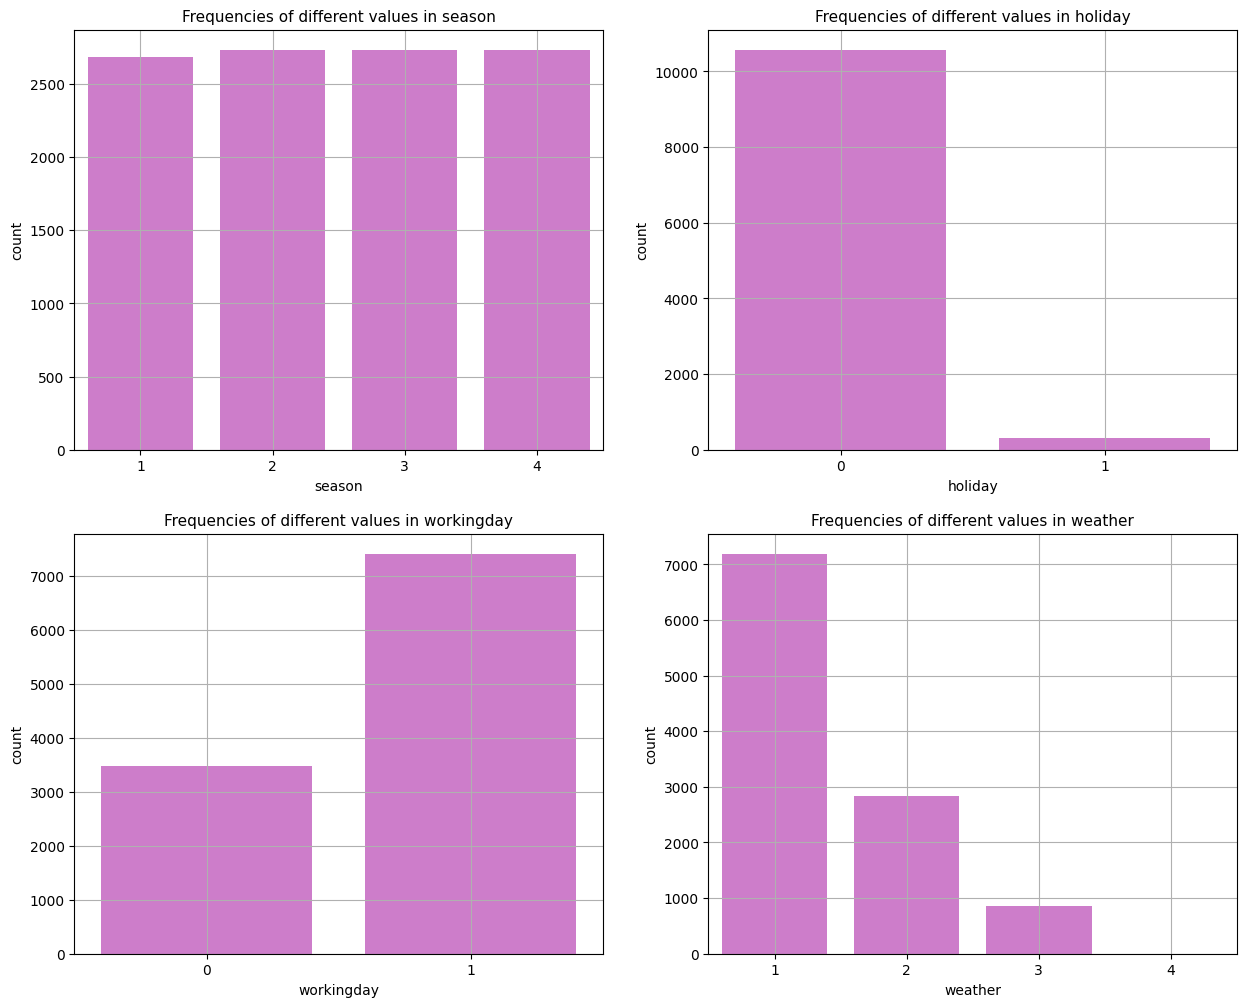

In [16]:
# Creating a countplot for all categorial columns
dummy = ['season', 'holiday', 'workingday', 'weather']
plt.figure(figsize = (15,12))
for i in range(4):
    plt.subplot(2,2,i+1)
    sns.countplot(x = df[dummy[i]], color = 'orchid')
    plt.title('Frequencies of different values in {x}'.format(x=dummy[i]), fontsize=11)
    plt.grid()
plt.show()

- Our dataset contains similar number of entries for all seasons.
- Majority of entries are not a holiday.
- About 7500 entries are of working days and about 3500 are of non-working days.
- About 7200 entries are of weather 1 (Clear, Few clouds, partly cloudy, partly cloudy), about 2800 of 2 (Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist), about 900 of 3 (Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds) and almost 0 of 4 (Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog).

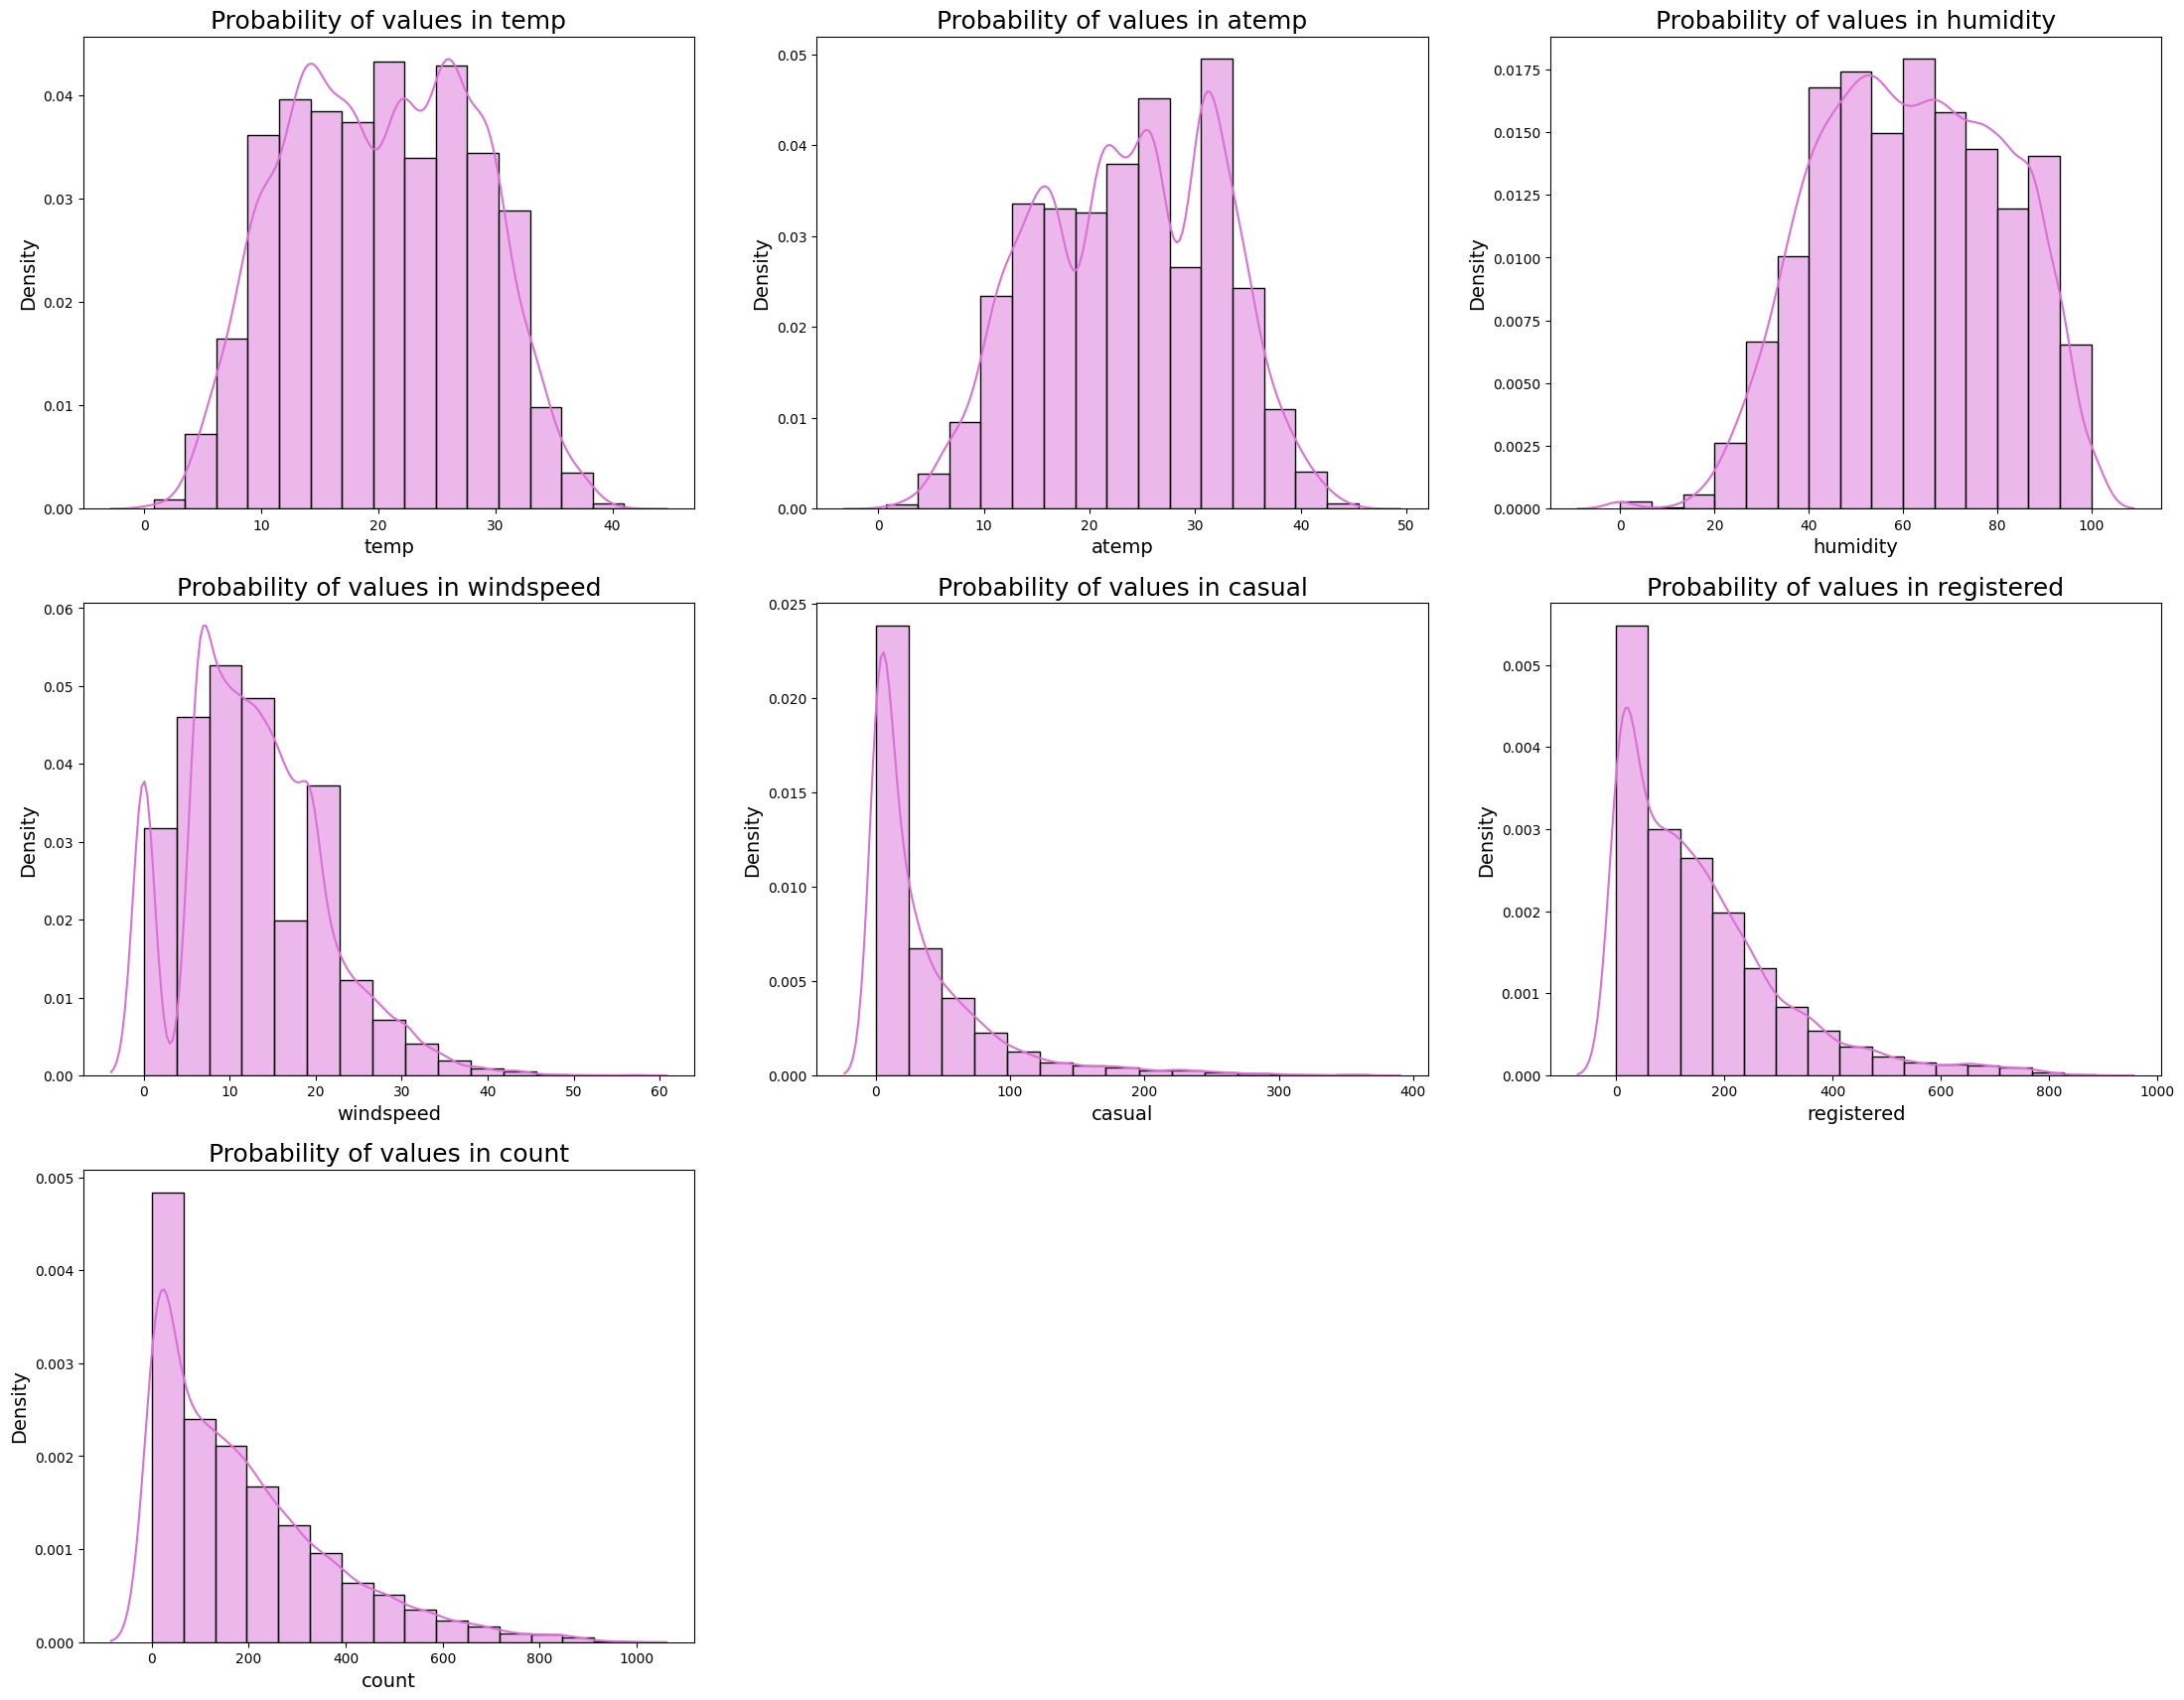

In [17]:
# Creating a distribution plot of all numerical columns-
dummy = ['temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count']
plt.figure(figsize=(27,21))
for i in range(7):
    plt.subplot(3,3,i+1)
    sns.histplot(x = df[dummy[i]], color = 'orchid', bins=15, kde = True, stat = 'density',kde_kws=dict(cut=3))
    plt.title('Probability of values in {x}'.format(x=dummy[i]), fontsize=18)
    plt.xlabel(dummy[i],fontsize = 14)
    plt.ylabel('Density',fontsize = 14)
plt.show()

- Most temperature values lie between 5 and 35 degrees.
- Most 'feels like' values lie between 5 and 40 degrees.
- Most humidity values lie between 20 and 100%.
- Most windspeed values lie between 0 and 40 kmph.
- Most number of casual users value lies between 0 and 200.
- Most number of registered users value lies between 0 and 600.
- Most total users values lie between 0 and 800.

Bivariate plots-

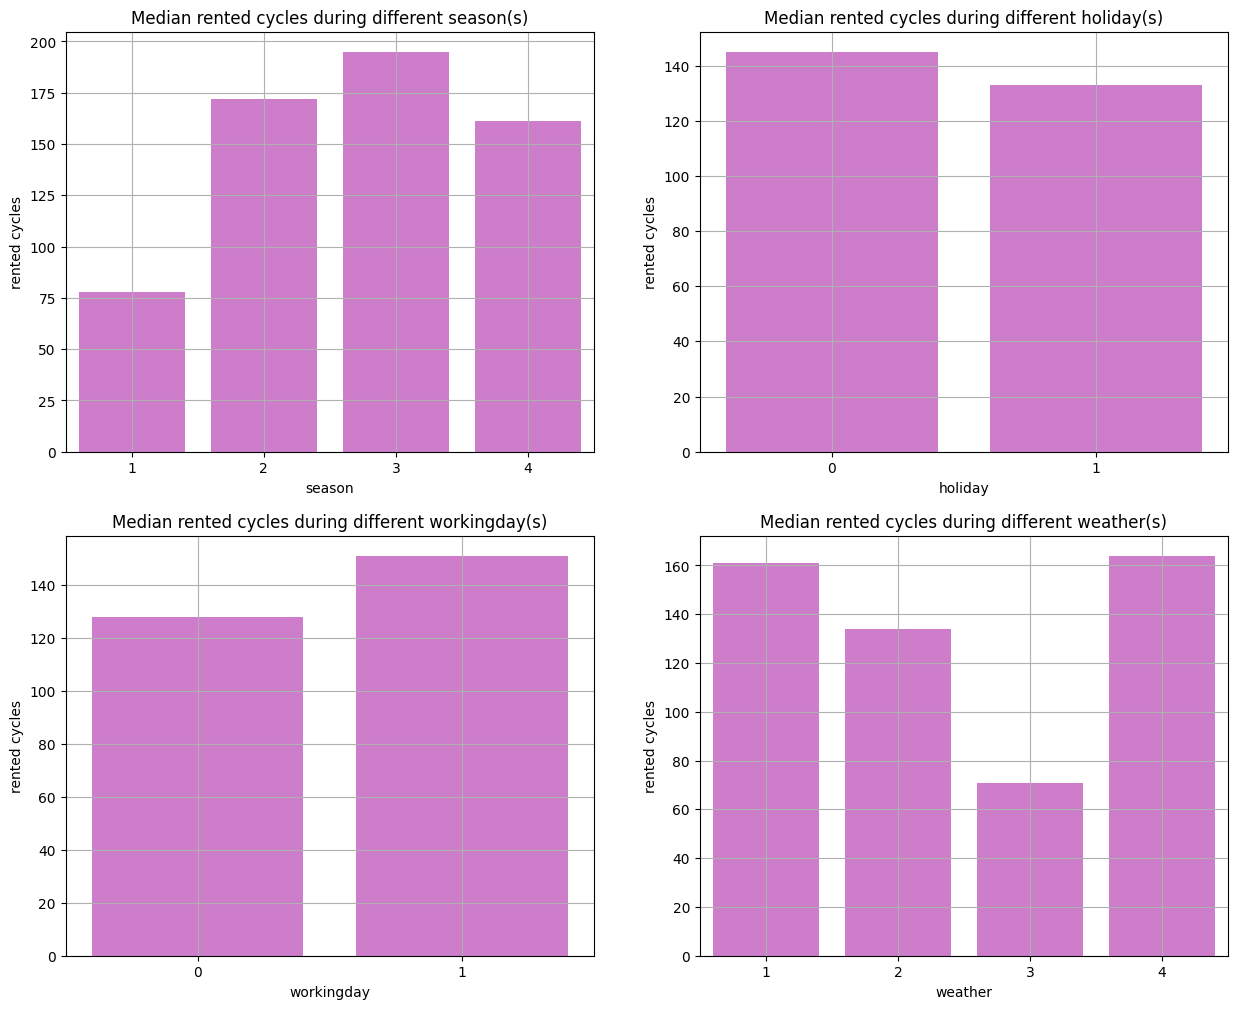

In [18]:
# Plotting categorical columns vs total users(count)
dummy = ['season', 'holiday', 'workingday', 'weather']
plt.figure(figsize = (15,12))
for i in range(4):
    plt.subplot(2,2,i+1)
    sns.barplot(x = df[dummy[i]], y = df['count'], color = 'orchid', estimator = 'median', errorbar = None)
    plt.title('Median rented cycles during different {x}(s)'.format(x=dummy[i]))
    plt.ylabel('rented cycles')
    plt.grid()
plt.show()

Insights- <br><br>
Median users is-
- highest for season 3 (fall).
- higher for non-holiday.
- higher for working days.
- high for weathers 1 (Clear, Few clouds, partly cloudy, partly cloudy) and 4 (Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog).

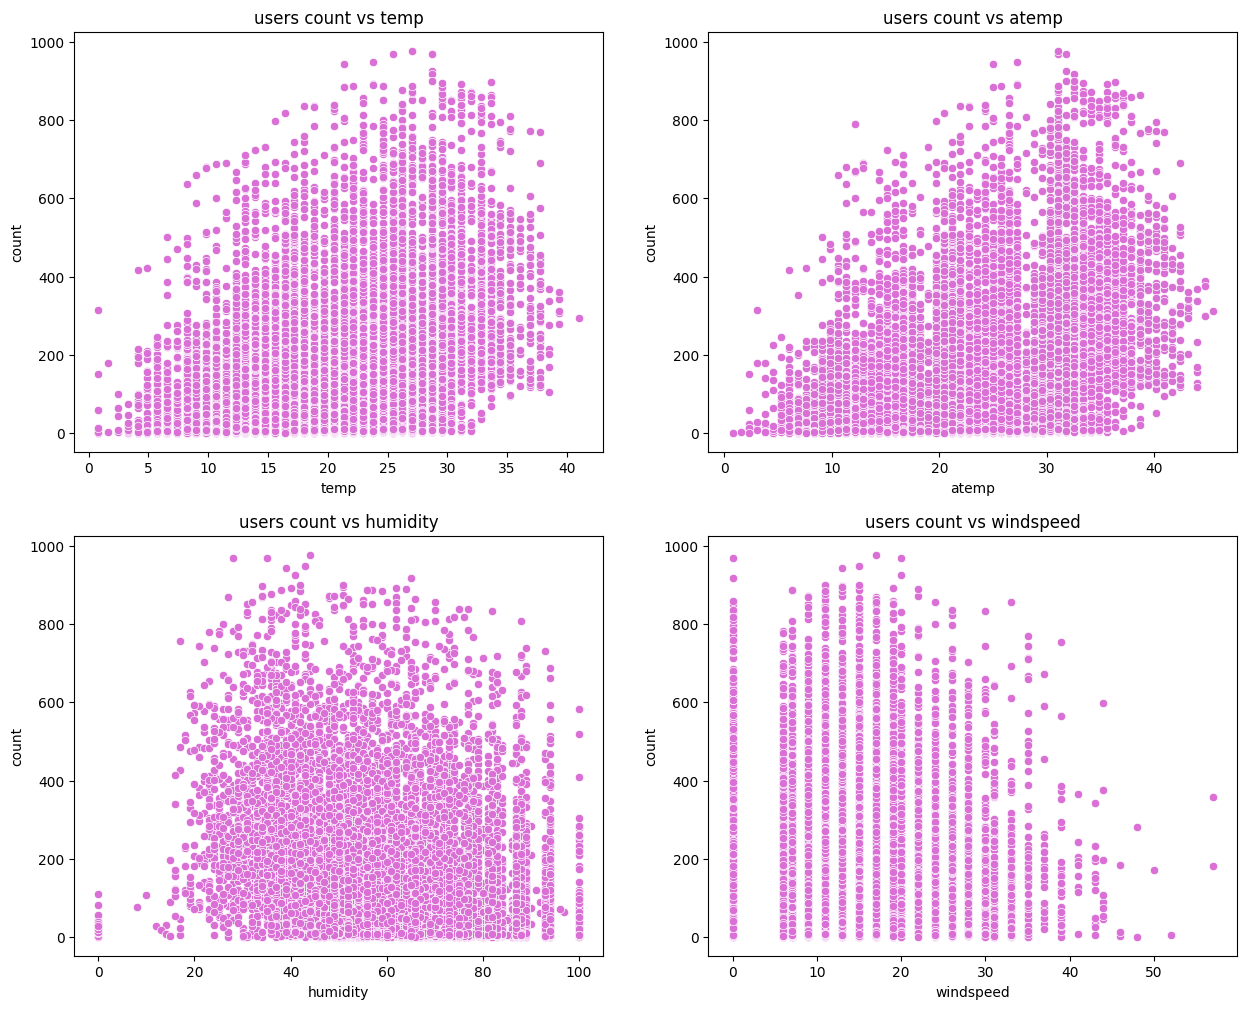

In [19]:
# Plotting scatter plots for numerical columns vs total users(count)
dummy = ['temp', 'atemp', 'humidity', 'windspeed']
plt.figure(figsize=(15,12))
for i in range(4):
    plt.subplot(2,2,i+1)
    sns.scatterplot(x=df[dummy[i]], y=df['count'], color = 'orchid')
    plt.title('users count vs {x}'.format(x=dummy[i]))
plt.show()

Insights-<br><br>
Number of users-
- Increases with increase in temperatue and 'feels like' temperature.
- Decreases with increase in humidity.
- Decreases with increase in windspeed.

# Hypothesis Testing

### Claim - Working day has an effect on number of electric cycles rented.

Creating null and alternate hypothesis to test the above claim.

H(0) = Working day doesn't have an effect on number of electric cycles rented.<br>
H(a) = Working day affects the number of electric cycles rented.

In [20]:
# Data for working day
workDay1 = df.loc[df['workingday']==1,'count']
# Data for non working day
workDay0 = df.loc[df['workingday']==0,'count']

Visual Analysis -

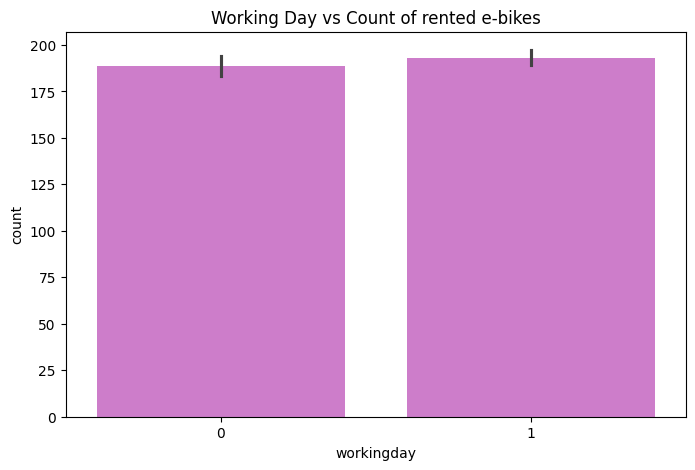

In [21]:
plt.figure(figsize=(8,5))
sns.barplot(x=df['workingday'], y = df['count'], color = 'orchid')
plt.title('Working Day vs Count of rented e-bikes')
plt.show()

The plot doesn't show much of a difference between working and non working days. We will check if the difference is statistically significant with the help of ttest.

Checking distribution of data-

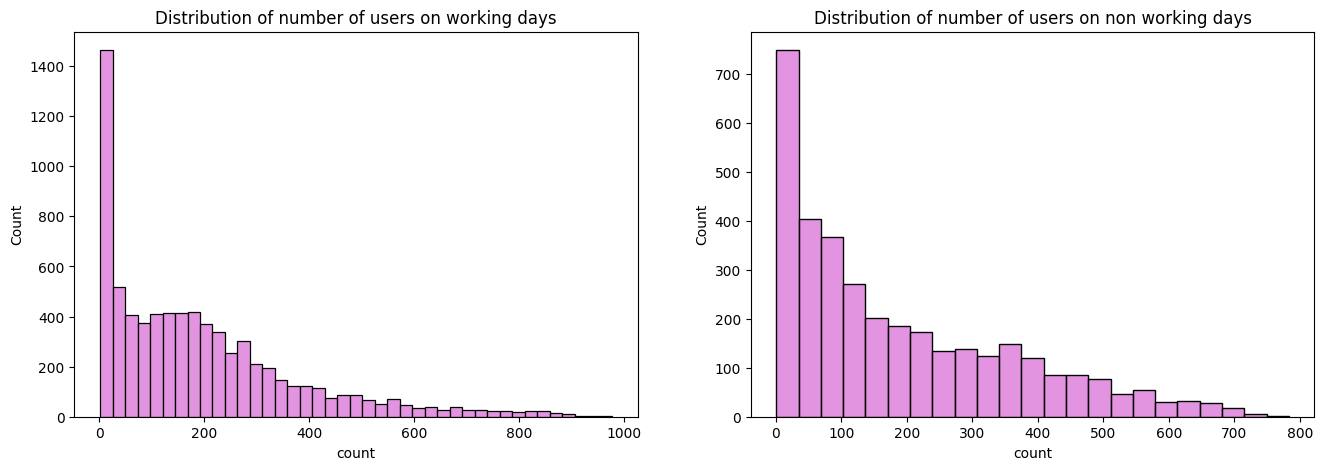

In [22]:
plt.figure(figsize = (16,5))
plt.subplot(121)
sns.histplot(workDay1, color = 'orchid')
plt.title('Distribution of number of users on working days')
plt.subplot(122)
sns.histplot(workDay0, color = 'orchid')
plt.title('Distribution of number of users on non working days')
plt.show()

The distributions doesn't look like gaussian at all.

Checking their qq plot to see if both data are gaussian-

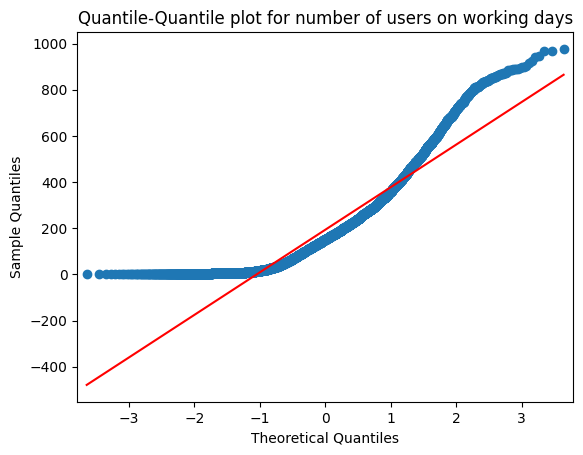

In [23]:
qqplot(workDay1, line='s')
plt.title('Quantile-Quantile plot for number of users on working days')
plt.show()

The qq-plot suggests that data is not gaussian.

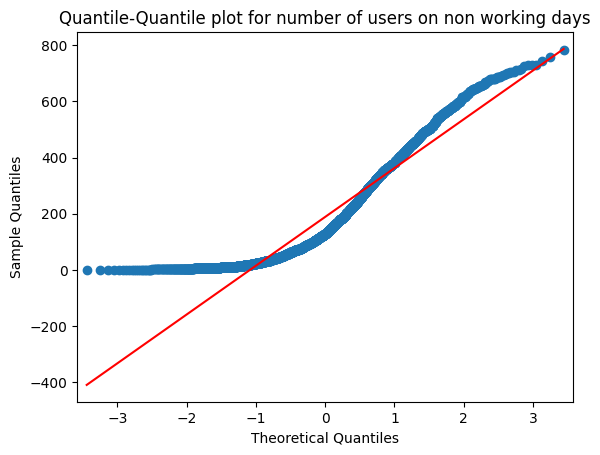

In [24]:
qqplot(workDay0, line='s')
plt.title('Quantile-Quantile plot for number of users on non working days')
plt.show()

The qq-plot suggests the above data is not gaussian.

Performing Shapiro test on both data to confirm data is not gaussian-

In [25]:
# Taking a sample of 100 because Shapiro works best between 50-200 sample size
dummy = workDay1.sample(100)
# H0: Data is Gaussian
# Ha: Data is not Gaussian
test_stat, p_value = shapiro(dummy)
print(p_value)
if p_value < 0.05:
    print("Reject H0")
    print("Working day data is not Gaussian")
else:
    print("Fail to reject H0")
    print("Working day data is Gaussian")
print('-'*50)
dummy = workDay0.sample(100)
# H0: Data is Gaussian
# Ha: Data is not Gaussian
test_stat, p_value = shapiro(dummy)
print(p_value)
if p_value < 0.05:
    print("Reject H0")
    print("Non-working day data is not Gaussian")
else:
    print("Fail to reject H0")
    print("Non-working day data is Gaussian")

2.739705351473276e-08
Reject H0
Working day data is not Gaussian
--------------------------------------------------
4.567085341022903e-07
Reject H0
Non-working day data is not Gaussian


Now comparing variance of both data-

In [26]:
# H0: same variance
# Ha: variance is different
test_stat, p_value = levene(workDay0, workDay1)
print(p_value)
if p_value < 0.05:
    print("Reject H0")
    print("Variances are different")
else:
    print("Fail to reject H0")
    print("Variances are the same")

0.9437823280916695
Fail to reject H0
Variances are the same


In [27]:
# Performing two tailed tailed ttest
ttest_ind(workDay1,workDay0)

TtestResult(statistic=1.2096277376026694, pvalue=0.22644804226361348, df=10884.0)

test statistic = 1.21 <br>
We get p-value = 0.23. <br>
Taking significance level of 5%. <br>
Since p-value is not low enough, we can't reject the null hypothesis.<br>
The difference between their means is not statistically significant. <br>
Conclusion - We <b> can't </b> say that workingday has an affect on electric cycles rented.

### Claim - Number of e-bikes rented varies with season

Creating null and alternate hypothesis for the above claim- <br>
H(0) = Number of e-bikes rented is same in all seasons. <br>
H(a) = Number of e-bikes rented varies with season.

In [28]:
# Data for number of cycles rented in different seasons
season1 = df.loc[df['season']==1, 'count']
season2 = df.loc[df['season']==2, 'count']
season3 = df.loc[df['season']==3, 'count']
season4 = df.loc[df['season']==4, 'count']

Visual Analysis -

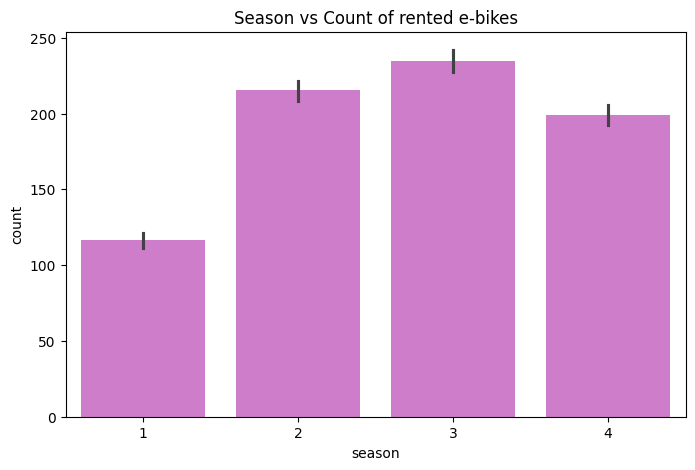

In [29]:
plt.figure(figsize=(8,5))
sns.barplot(x=df['season'], y = df['count'], color = 'orchid')
plt.title('Season vs Count of rented e-bikes')
plt.show()

The graph suggests that number of rented e-bikes varies with season. We will check if this variation is statistically significant with the help of ANOVA test.

Checking their distribution-

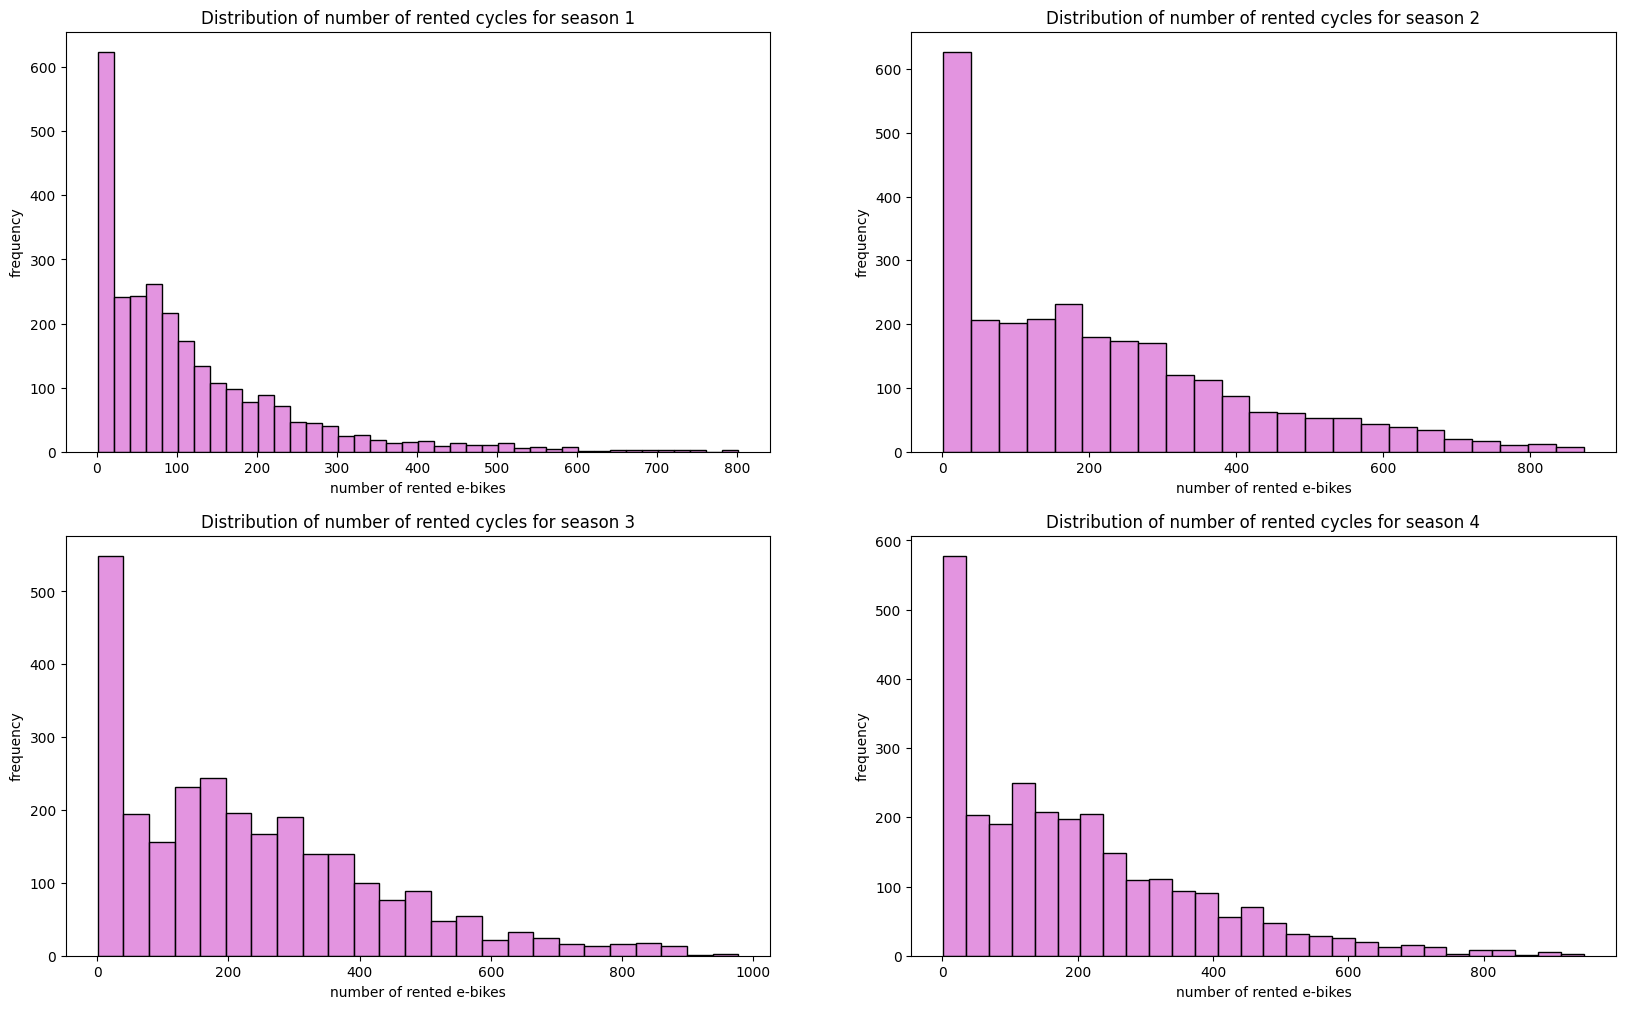

In [30]:
dummy = [season1, season2, season3, season4]
plt.figure(figsize=(20,12))
for i in range(4):
    plt.subplot(2,2,i+1)
    sns.histplot(dummy[i], color = 'orchid')
    plt.title('Distribution of number of rented cycles for season {x}'.format(x=i+1), fontsize = 12)
    plt.ylabel('frequency')
    plt.xlabel('number of rented e-bikes')
plt.show()

The distributions don't appear to be gaussion.

Checking the qq-plot to furthur analyse the nature of distribution-

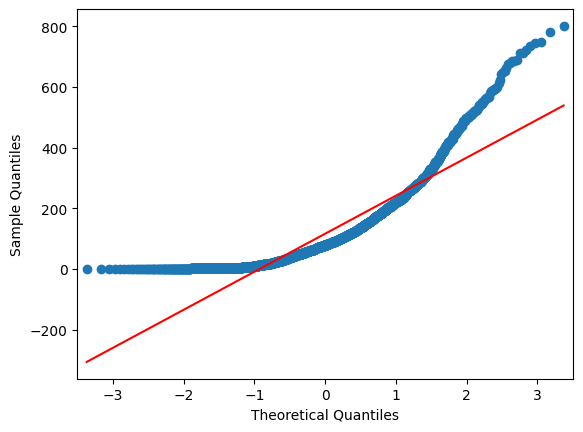

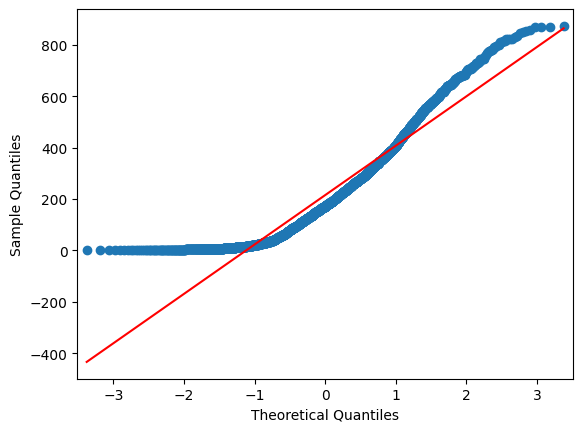

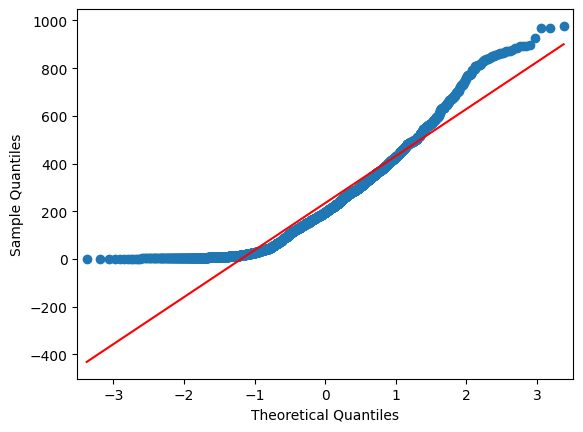

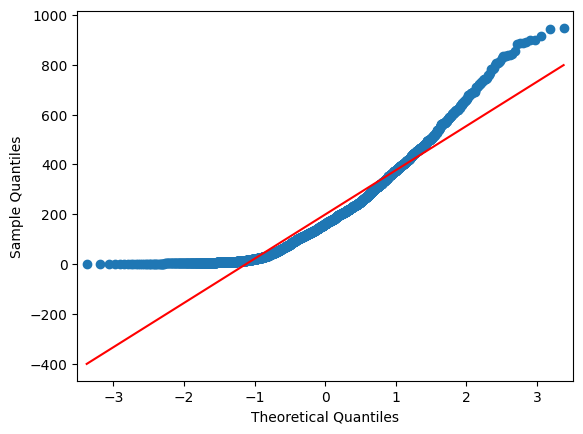

In [31]:
qqplot(season1, line="s")
qqplot(season2, line='s')
qqplot(season3, line='s')
qqplot(season4, line='s')
plt.show()

None of the data appear to be gaussian.

Performing shapiro test to check whether data is gaussian-

In [32]:
# Taking a sample of 100 for each season because Shapiro works best for sample size 50-200
dummy = [season1.sample(100), season2.sample(100), season3.sample(100), season4.sample(100)]
for i in range(4):
    # H0: Data is Gaussian
    # Ha: Data is not Gaussian
    test_stat, p_value = shapiro(dummy[i])
    print(p_value)
    if p_value < 0.05:
        print("Reject H0")
        print("Season {x} data is not Gaussian".format(x=i+1))
    else:
        print("Fail to reject H0")
        print("Season {x} data is Gaussian".format(x=i+1))
    print('-'*50)

4.7445254836020467e-07
Reject H0
Season 1 data is not Gaussian
--------------------------------------------------
5.28072541783331e-06
Reject H0
Season 2 data is not Gaussian
--------------------------------------------------
9.695199878478888e-07
Reject H0
Season 3 data is not Gaussian
--------------------------------------------------
7.314119443435629e-07
Reject H0
Season 4 data is not Gaussian
--------------------------------------------------


Now, comparing variance of both data-

In [33]:
# Checking the standard deviations of each season's data
(season1.std(), season2.std(), season3.std(), season4.std())

(125.27397388810313,
 192.00784313546262,
 197.15100053680393,
 177.62240938763696)

In [34]:
# H0: same variance
# Ha: variance is different
test_stat, p_value = levene(season1, season2, season3, season4)
print(p_value)
if p_value < 0.05:
    print("Reject H0")
    print("Variances are different")
else:
    print("Fail to reject H0")
    print("Variances are the same")

1.0147116860043298e-118
Reject H0
Variances are different


Performing ANOVA on the data to test whether seasons affect usage of cycles-

In [35]:
f_oneway(season1, season2, season3, season4)

F_onewayResult(statistic=236.94671081032106, pvalue=6.164843386499654e-149)

test statistic = 236.94 <br>
p value = 6.16 x 10^(-149) <br>
Taking significance level to be 5%. <br>
p-value is very small.<br>
We reject the null hypothesis.<br>
Conclusion - Number of e-bikes rented are different in different seasons.

Since the assumptions for ANOVA had failed, let's perform kruskal test as well-

In [36]:
kruskal(season1, season2, season3, season4)

KruskalResult(statistic=699.6668548181988, pvalue=2.479008372608633e-151)

Kruskal test gives us the same conclusion- <br>
Number of e-bikes rented are different in different seasons.

### Claim - Number of e-bikes rented varies with weather

Creating null and alternate hypothesis to test the above claim- <br>
H(0) - Number of e-bikes rented doesn't vary with weather<br>
H(a) - Number of e-bikes rented varies with weather

In [37]:
# Data for different weathers
weather1 = df.loc[df['weather']==1, 'count']
weather2 = df.loc[df['weather']==2, 'count']
weather3 = df.loc[df['weather']==3, 'count']
weather4 = df.loc[df['weather']==4, 'count']

Visual analysis-

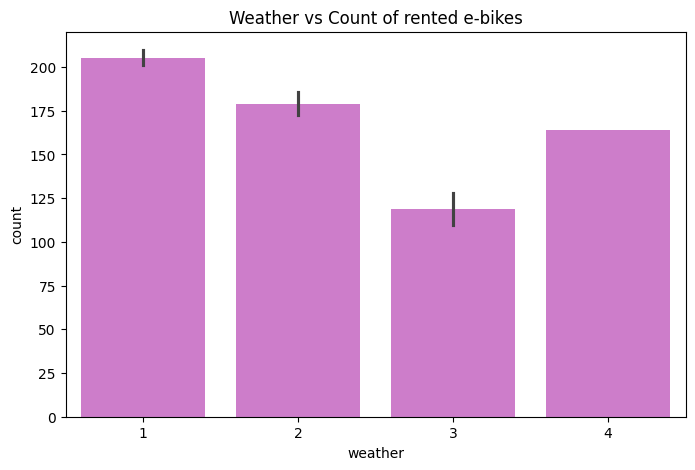

In [38]:
plt.figure(figsize=(8,5))
sns.barplot(x=df['weather'], y = df['count'], color = 'orchid')
plt.title('Weather vs Count of rented e-bikes')
plt.show()

The graph suggests that number of rented e-bikes varies with weather. We will check if this variation is statistically significant with the help of ANOVA test.

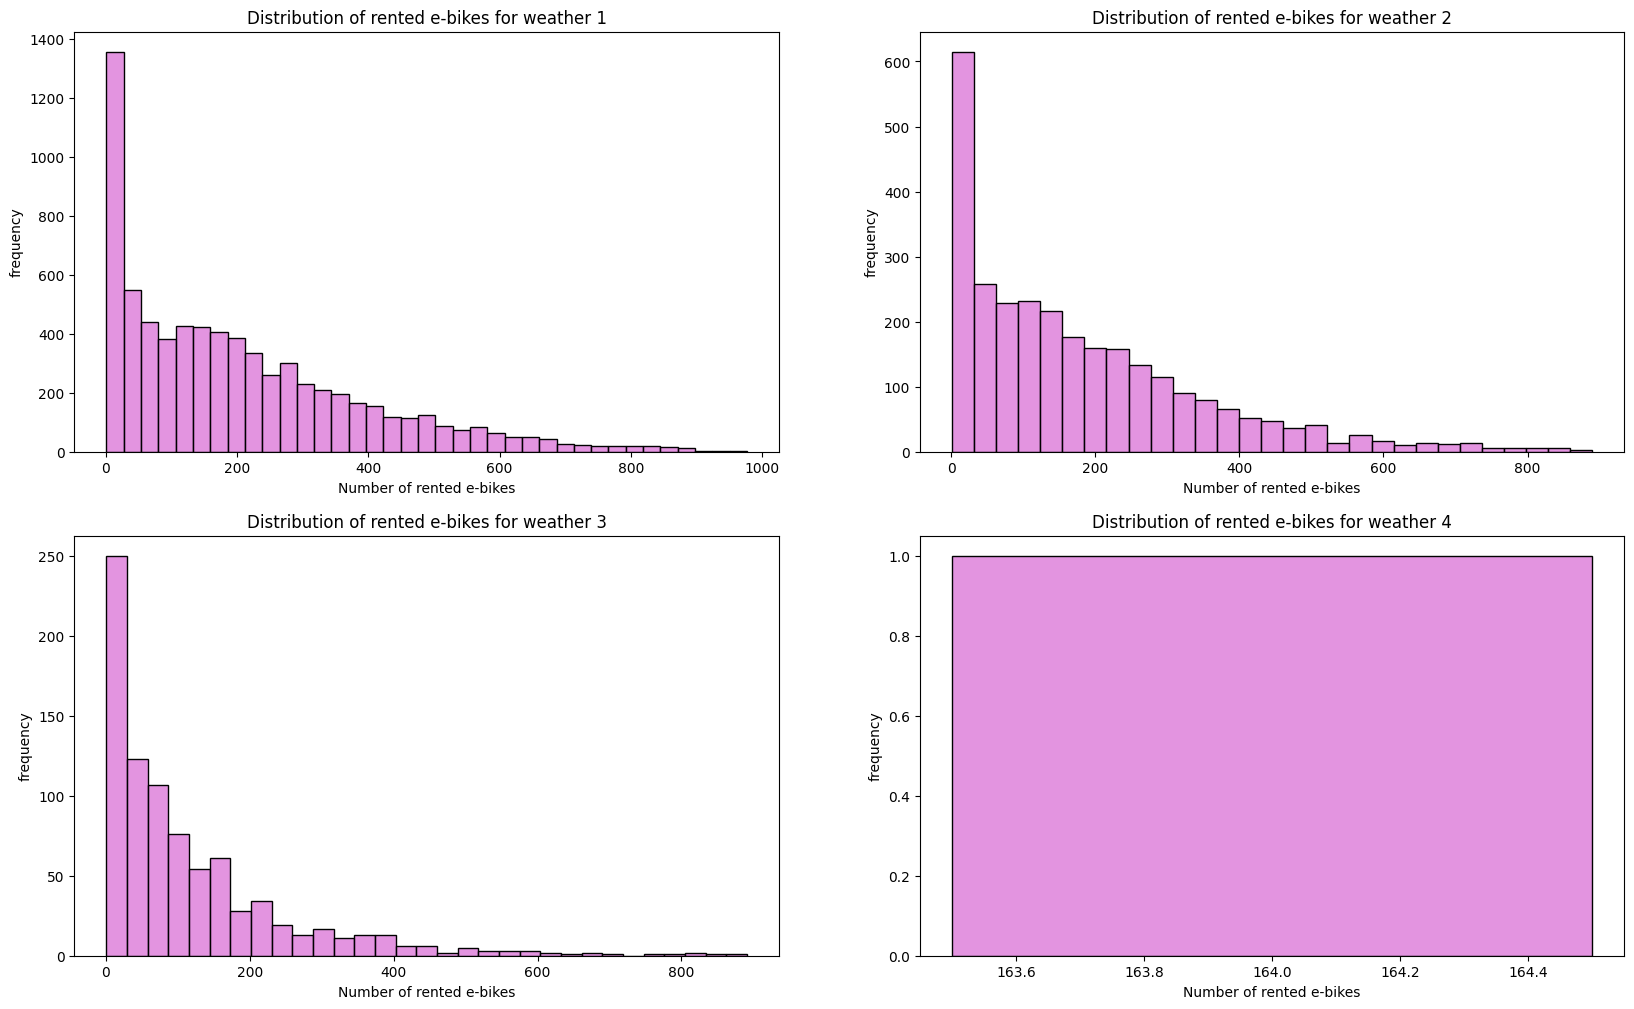

In [39]:
# Plotting histograms to check their distributions
dummy = [weather1, weather2, weather3, weather4]
plt.figure(figsize = (20,12))
for i in range(4):
    plt.subplot(2,2,i+1)
    sns.histplot(dummy[i], color='orchid')
    plt.title('Distribution of rented e-bikes for weather {x}'.format(x=i+1), fontsize = 12)
    plt.xlabel('Number of rented e-bikes')
    plt.ylabel('frequency')
plt.show()

The data is not bell-shaped. It isn't gaussian.

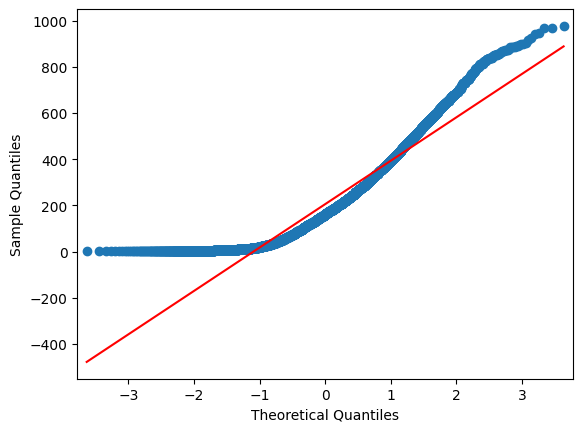

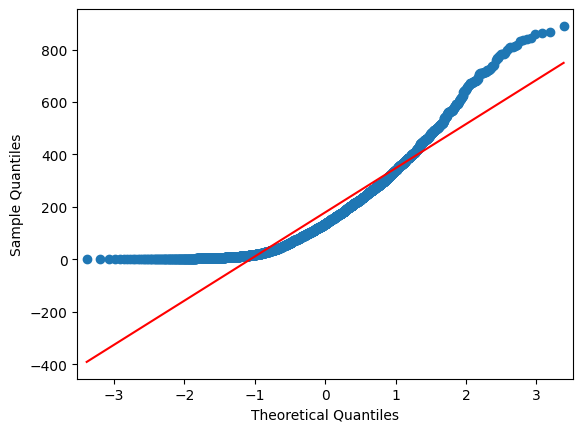

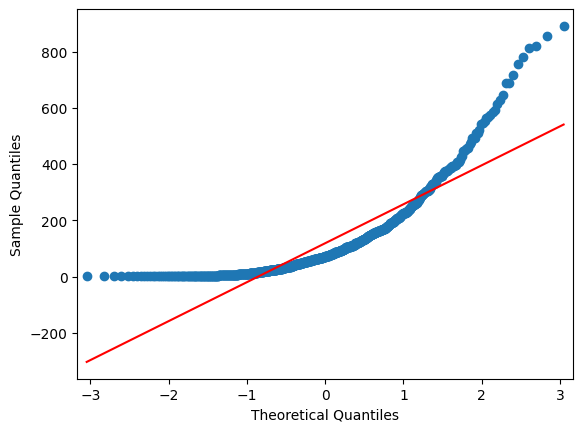

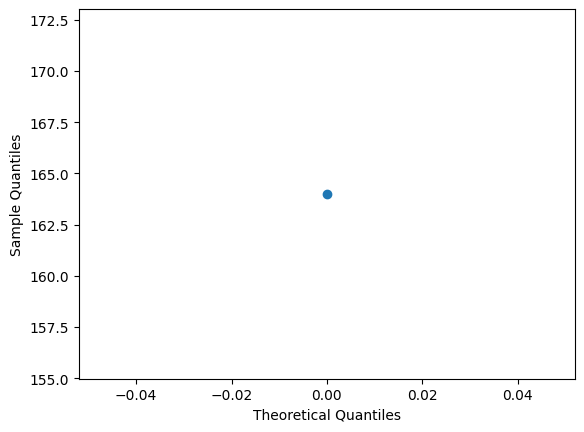

In [40]:
# Creating qq-plots for all weathers
qqplot(weather1, line = 's')
qqplot(weather2, line = 's')
qqplot(weather3, line = 's')
qqplot(weather4, line = 's')
plt.show()

We get only a dot for weather 4 because it has only one record.<br>
Data for weathers is not gaussian.

In [41]:
# Taking samples of 100 for Shapiro test
dummy = [weather1.sample(100), weather2.sample(100), weather3.sample(100)] # can't take weather 4 because of insufficient data
for i in range(3):
    test_stat, p_value = shapiro(dummy[i])
    if p_value < 0.05:
        print("Reject H0")
        print("Weather {x} data is not Gaussian".format(x=i+1))
    else:
        print("Fail to reject H0")
        print("Weather {x} data is Gaussian".format(x=i+1))
    print('-'*50)

Reject H0
Weather 1 data is not Gaussian
--------------------------------------------------
Reject H0
Weather 2 data is not Gaussian
--------------------------------------------------
Reject H0
Weather 3 data is not Gaussian
--------------------------------------------------


In [42]:
# Performing levene's test to check if they have same variance.
# H0: same variance
# Ha: variance is different
test_stat, p_value = levene(weather1, weather2, weather3)
print(p_value)
if p_value < 0.05:
    print("Reject H0")
    print("Variances are different")
else:
    print("Fail to reject H0")
    print("Variances are the same")

6.198278710731511e-36
Reject H0
Variances are different


Performing ANOVA to check if number of rented e-bikes differ with weather-

In [43]:
f_oneway(weather1, weather2, weather3)

F_onewayResult(statistic=98.28356881946706, pvalue=4.976448509904196e-43)

test statistic = 98.28 <br>
p value = 4.98 x 10^(-43) <br>
Taking significance level to be 5%. <br>
Since p value is very small, we will reject the null hypothesis. <br>
Conclusion - Number of rented e-bikes differ with weather.

Since the distributions for above data were not gaussian, which is an assumption for ANOVA, let's perform kruskal-

In [44]:
kruskal(weather1, weather2, weather3)

KruskalResult(statistic=204.95566833068537, pvalue=3.122066178659941e-45)

Kruskal gives us the same conclusion-<br>
Number of e-bikes rented varies with weather.

### Claim - Weather is dependent on season

Creating null and alternate hypothesis to test the claim- <br>
H(0) - Weather is independent of season <br>
H(a) - Weather is dependent on season

In [45]:
# Data for weather vs season
contingency_tbl = pd.crosstab(df['weather'], df['season'])
contingency_tbl

season,1,2,3,4
weather,,,,
1,1759,1801,1930,1702
2,715,708,604,807
3,211,224,199,225
4,1,0,0,0


In [46]:
# Removing weather 4 because of insufficient data
contingency_tbl = contingency_tbl.loc[:3]
contingency_tbl

season,1,2,3,4
weather,,,,
1,1759,1801,1930,1702
2,715,708,604,807
3,211,224,199,225


Visual analysis-

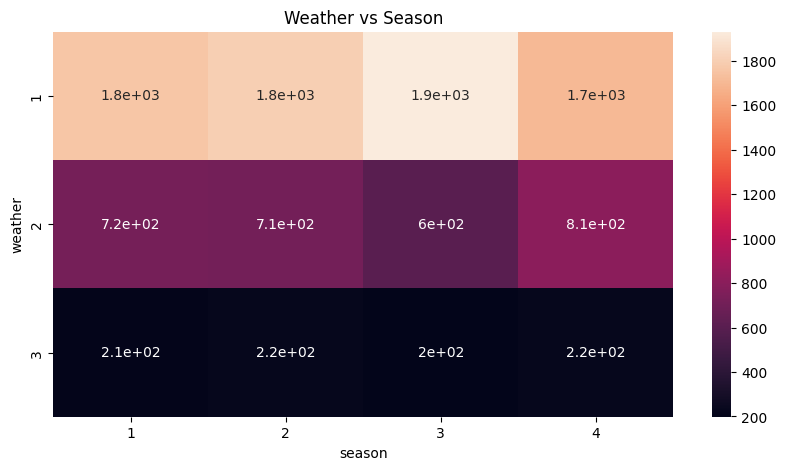

In [47]:
plt.figure(figsize = (10,5))
sns.heatmap(contingency_tbl, annot = True)
plt.title('Weather vs Season')
plt.show()

We see some variation in weather as we change season. We will check if the difference is statistically significant using chi square test.

Assumptions of Chi Square test-
1. Variables are categorical
2. Observations are independent
3. Each cell is mutually exclusive
4. Expected value in each cell is greater than 5.

First 3 assumptions seem to be valid. 4th assumption will be checked in next step.

In [48]:
# Performing chi2_contingency test-
chi2_contingency(contingency_tbl)

Chi2ContingencyResult(statistic=46.101457310732485, pvalue=2.8260014509929403e-08, dof=6, expected_freq=array([[1774.04869086, 1805.76352779, 1805.76352779, 1806.42425356],
       [ 699.06201194,  711.55920992,  711.55920992,  711.81956821],
       [ 211.8892972 ,  215.67726229,  215.67726229,  215.75617823]]))

test statistic = 46.101 <br>
p value = 2.82 x 10^(-08) <br>
Taking significance level of 5%. <br>
p value is lower than 0.05. <br>
We reject the null hypothesis. <br>
Conclusion - Weather and season depend on each other.

# Insights and Recommendations

Insights-
- Number of e-bikes rented varies with season.
- Number of e-bikes rented varies with weather.
- Weather depends on season.
- Rented e-bikes increase with increase in temperature.
- Demand decreases with increase in humidity.
- Demand decreases with increase in wind speed.

Recommendations-
- Service the e-bikes during season 1 (spring), when demand is low. So that more bikes are available during seasons 2,3 and 4 when demand is higher.
- Run ads during season 3 (fall) because people are more likely to use e-bikes during fall.
- Provide raincoats with e-bikes to increase demand during weather 3 (Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds).

Let's try to predict 'count' using the other features.

## Building a neural network model to predict 'count'

Note that count here refers to the total count of rental bikes at that point of time including registered and casual users.<br>
First, we need to do some preprocessing.

In [49]:
df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32


We have to-
1. Separate hour, day, month and year from datetime.
1. Drop datetime, casual and registered columns
1. Splitting into train and test data
1. Standardize the features.

In [50]:
# Separating hour, day, month and year from datetime
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['hour'] = df['datetime'].dt.hour

In [51]:
df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2


In [52]:
# Dropping unnecessary columns
df.drop(['datetime', 'casual', 'registered'], axis=1, inplace = True)

In [53]:
df.head(1)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour
0,1,0,0,1,9.84,14.395,81,0.0,16,2011,1,1,0


In [54]:
# Separating input features and target
X = pd.concat([df.loc[:, 'season' : 'windspeed'], df.loc[:, 'year' : 'hour']], axis = 1)
y = df['count']

In [55]:
X.head(3)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,hour
0,1,0,0,1,9.84,14.395,81,0.0,2011,1,1,0
1,1,0,0,1,9.02,13.635,80,0.0,2011,1,1,1
2,1,0,0,1,9.02,13.635,80,0.0,2011,1,1,2


In [56]:
# Splitting into training and testing data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

Note that we kept the test data small because our dataset has only 11,000 rows which is a small number for training a model.

In [57]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [58]:
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.metrics import mean_absolute_error

In [67]:
from numpy.random import seed
seed(42)
from tensorflow.random import set_seed
set_seed(42)
import keras
keras.utils.set_random_seed(42)

In [115]:
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 128)               1664      
                                                                 
 dense_13 (Dense)            (None, 256)               33024     
                                                                 
 dense_14 (Dense)            (None, 256)               65792     
                                                                 
 dense_15 (Dense)            (None, 1)                 257       
                                                                 
Total params: 100737 (393.50 KB)
Trainable params: 100737 (393.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [116]:
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5'
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [117]:
history = NN_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)

Epoch 1/100
240/245 [============================>.] - ETA: 0s - loss: 116.1263 - mean_absolute_error: 116.1263
Epoch 1: val_loss improved from inf to 98.69795, saving model to Weights-001--98.69795.hdf5
245/245 [==============================] - 3s 6ms/step - loss: 115.6497 - mean_absolute_error: 115.6497 - val_loss: 98.6980 - val_mean_absolute_error: 98.6980
Epoch 2/100
 26/245 [==>...........................] - ETA: 0s - loss: 100.8426 - mean_absolute_error: 100.8426

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


237/245 [============================>.] - ETA: 0s - loss: 96.6998 - mean_absolute_error: 96.6998
Epoch 2: val_loss improved from 98.69795 to 92.32059, saving model to Weights-002--92.32059.hdf5
245/245 [==============================] - 1s 5ms/step - loss: 96.7922 - mean_absolute_error: 96.7922 - val_loss: 92.3206 - val_mean_absolute_error: 92.3206
Epoch 3/100
245/245 [==============================] - ETA: 0s - loss: 88.7945 - mean_absolute_error: 88.7945
Epoch 3: val_loss improved from 92.32059 to 79.49498, saving model to Weights-003--79.49498.hdf5
245/245 [==============================] - 1s 4ms/step - loss: 88.7945 - mean_absolute_error: 88.7945 - val_loss: 79.4950 - val_mean_absolute_error: 79.4950
Epoch 4/100
227/245 [==========================>...] - ETA: 0s - loss: 77.8583 - mean_absolute_error: 77.8583
Epoch 4: val_loss improved from 79.49498 to 69.06935, saving model to Weights-004--69.06935.hdf5
245/245 [==============================] - 1s 3ms/step - loss: 77.5650 - mean

In [118]:
# Load weights file of the best model :
weights_file = 'Weights-095--25.61999.hdf5' # choose the best checkpoint
NN_model.load_weights(weights_file) # load it
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

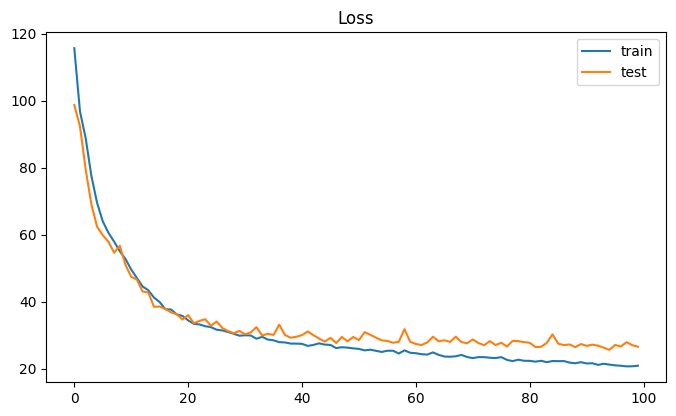

In [119]:
plt.figure(figsize = (8, 10))
# plot loss during training
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

In [120]:
_,train_loss = NN_model.evaluate(X_train, y_train)
print('Training loss :', train_loss)
_,test_loss = NN_model.evaluate(X_test, y_test)
print('Testing loss :', test_loss)

307/307 [==============================] - 1s 2ms/step - loss: 20.8881 - mean_absolute_error: 20.8881
Training loss : 20.88813591003418
35/35 [==============================] - 0s 2ms/step - loss: 26.4223 - mean_absolute_error: 26.4223
Testing loss : 26.422300338745117


In [121]:
y_pred = NN_model.predict(X_test)

35/35 [==============================] - 0s 2ms/step


In [122]:
tp = pd.DataFrame({'Actual' : y_test.values, 'Predicted' : y_pred.flatten()})

In [123]:
tp['Predicted'] = tp['Predicted'].apply(lambda x: round(x, 2))

In [125]:
tp.head(10)

,Actual,Predicted
0,127,132.36
1,13,18.70
2,163,152.84
3,233,206.58
4,222,158.38
5,166,165.14
6,144,133.98
7,376,362.22
8,601,616.91
9,53,52.74


- MAE for test data is 26.42.
- The model is overfitted. We should stop the training process early. <br>

Leaving it here for now. Thanks for reading!